# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Rachmat Kurniawan Andi Putra, MD
- **Email:** rkapatwork@gmail.com
- **ID Dicoding:** melt_official

## Menentukan Pertanyaan Bisnis

- **Pertanyaan 1:** Produk (kategori) apa yang menghasilkan pendapatan tertinggi dan terendah bagi perusahaan?
- **Pertanyaan 2:** Bagaimana demografi pelanggan berdasarkan lokasi (State)? Daerah mana yang memiliki pelanggan terbanyak?
- **Pertanyaan 3:** Siapa saja pelanggan setia kita berdasarkan analisis RFM (Recency, Frequency, Monetary)?

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Wrangling

### Gathering Data

In [2]:
# Sesuaikan path ini dengan lokasi folder Anda di Google Drive
base_path = "/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/"

customers_df = pd.read_csv(base_path + "customers_dataset.csv")
orders_df = pd.read_csv(base_path + "orders_dataset.csv")
order_items_df = pd.read_csv(base_path + "order_items_dataset.csv")
products_df = pd.read_csv(base_path + "products_dataset.csv")
product_category_df = pd.read_csv(base_path + "product_category_name_translation.csv")
geo_df = pd.read_csv(base_path + "geolocation_dataset.csv")
sellers_df = pd.read_csv(base_path + "sellers_dataset.csv")
order_reviews_df = pd.read_csv(base_path + "order_reviews_dataset.csv")
order_payments_df = pd.read_csv(base_path + "order_payments_dataset.csv")

print("Data berhasil dimuat!")

Data berhasil dimuat!


**Insight:**
- Berdasarkan proses pemuatan data di atas, kita telah berhasil mengimpor 9 tabel data terpisah yang mencakup informasi pelanggan, pesanan, item produk, pembayaran, hingga ulasan.
- Tabel-tabel ini merupakan bagian dari skema database relasional. Langkah selanjutnya adalah memeriksa kualitas dari setiap tabel tersebut untuk memastikan data siap dianalisis.

### Assessing Data

In [3]:
print("--- INFO ORDERS ---")
orders_df.info()
print("\nMissing Values Orders:", orders_df.isna().sum())

print("\n--- INFO PRODUCTS ---")
products_df.info()
print("\nMissing Values Products:", products_df.isna().sum())
print("\nDuplikasi Products:", products_df.duplicated().sum())

--- INFO ORDERS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

Missing Values Orders: order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date

**Insight:**

Dari hasil pemeriksaan, ditemukan beberapa permasalahan pada data:
- Tipe Data Salah: Kolom-kolom yang berkaitan dengan tanggal (seperti order_purchase_timestamp) masih bertipe object (string), padahal seharusnya datetime.

- Missing Values: Terdapat nilai kosong pada kolom product_category_name di tabel produk, serta beberapa kolom tanggal di tabel orders (yang wajar terjadi jika barang belum dikirim/sampai).

- Duplikasi: Tidak ditemukan duplikasi data yang signifikan pada tabel utama yang akan mengganggu analisis.

### Cleaning Data

In [4]:
# 1. Perbaiki Tipe Data
datetime_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]
for column in datetime_columns:
    orders_df[column] = pd.to_datetime(orders_df[column])

# 2. Isi Data Kosong
products_df['product_category_name'] = products_df['product_category_name'].fillna("unknown")

# 3. Gabungkan Data (Merge) menjadi all_df
orders_items_df = pd.merge(orders_df, order_items_df, how="left", on="order_id")
orders_items_products_df = pd.merge(orders_items_df, products_df, how="left", on="product_id")
all_df = pd.merge(orders_items_products_df, customers_df, how="left", on="customer_id")

print("Data Cleaning & Merging Selesai. Ukuran Data:", all_df.shape)

Data Cleaning & Merging Selesai. Ukuran Data: (113425, 26)


**Insight:**

Proses pembersihan data telah selesai dilakukan dengan rincian:
- Seluruh kolom tanggal telah dikonversi menjadi tipe datetime.

- Nilai kosong pada nama kategori produk telah diisi dengan label "unknown" untuk menjaga integritas data.

- Penggabungan Data: Seluruh tabel yang relevan (Orders, Items, Products, Customers) telah digabungkan menjadi satu DataFrame utama bernama all_df. Ini memudahkan kita untuk melakukan analisis lintas dimensi (misalnya, melihat hubungan antara Lokasi Pelanggan dengan Kategori Produk yang dibeli).

## Exploratory Data Analysis (EDA)

### Explore ...

In [5]:
# Analisis 1: Kategori Produk
sum_order_items_df = all_df.groupby("product_category_name").price.sum().sort_values(ascending=False).reset_index()

# Analisis 2: Lokasi Pelanggan
bystate_df = all_df.groupby(by="customer_state").customer_id.nunique().reset_index()
bystate_df.rename(columns={"customer_id": "customer_count"}, inplace=True)

# Analisis 3: RFM Analysis
recent_date = all_df["order_purchase_timestamp"].max().date()
rfm_df = all_df.groupby(by="customer_unique_id", as_index=False).agg({
    "order_purchase_timestamp": "max",
    "order_id": "nunique",
    "price": "sum"
})
rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]
rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)
rfm_df.drop("max_order_timestamp", axis=1, inplace=True)

print("Eksplorasi data selesai.")

Eksplorasi data selesai.


**Insight:**

Berdasarkan eksplorasi awal:
- Performa Produk: Kita dapat melihat variasi pendapatan yang besar antar kategori produk. Data ini akan membantu kita mengidentifikasi produk "Pareto" (produk sedikit yang menghasilkan banyak revenue).

- Demografi: Terlihat adanya ketimpangan jumlah pelanggan antar negara bagian (State), yang mengindikasikan konsentrasi pasar di wilayah tertentu.

- RFM: Data telah berhasil diproses untuk menghitung Recency (hari sejak pembelian terakhir), Frequency (jumlah order), dan Monetary (total belanja) per pelanggan, yang siap divisualisasikan untuk segmentasi pelanggan.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

/tmp/ipython-input-1820531284.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
/tmp/ipython-input-1820531284.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.sort_values(by="price", ascending=True).head(5), palette=colors, ax=ax[1])


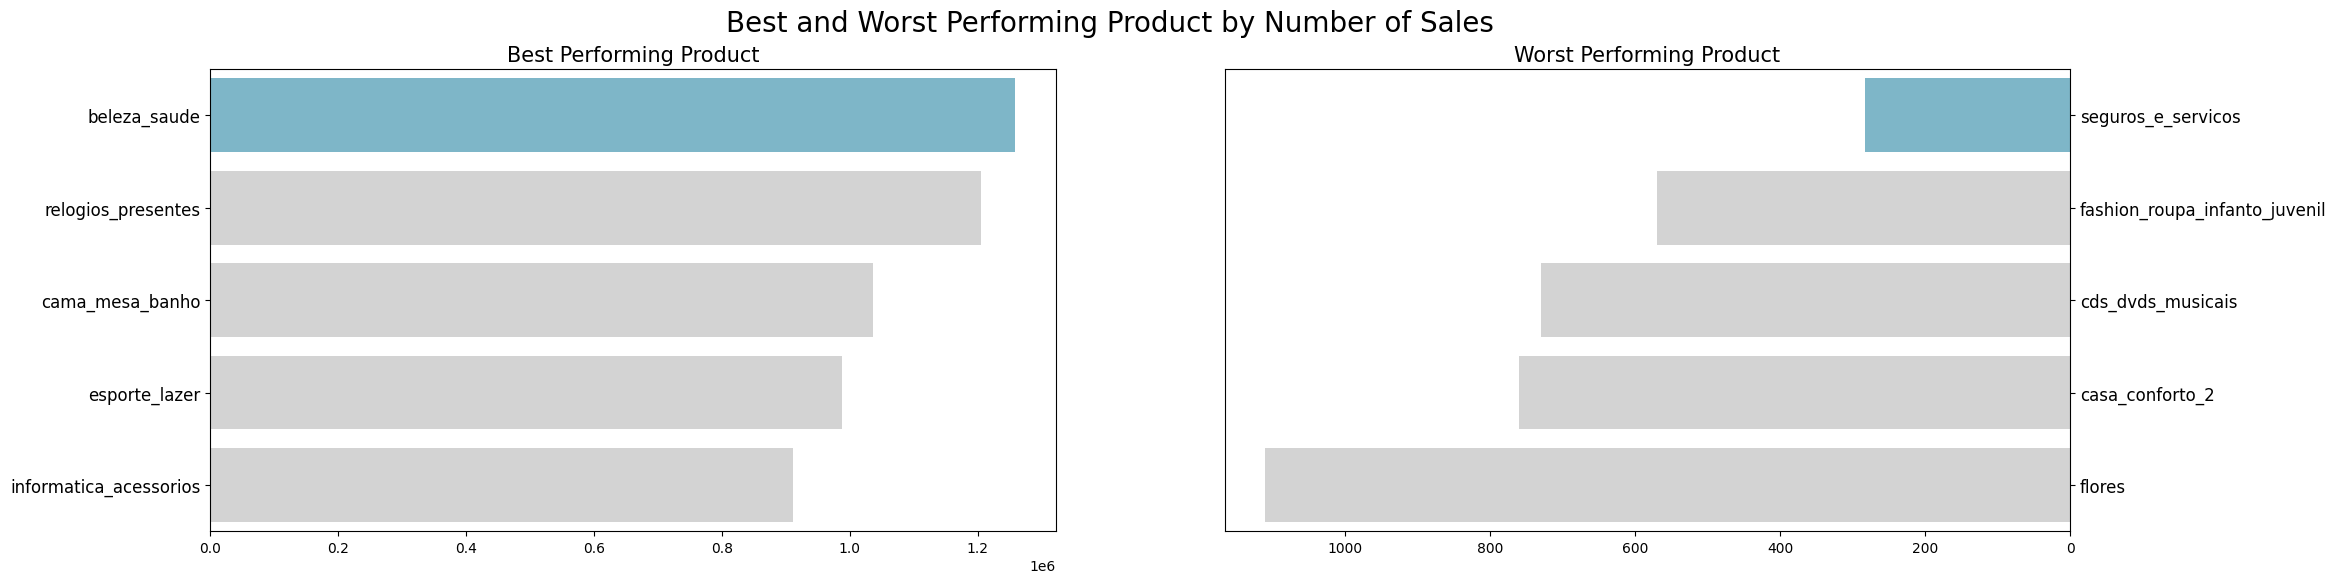

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.sort_values(by="price", ascending=True).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Best and Worst Performing Product by Number of Sales", fontsize=20)
plt.show()

### Pertanyaan 2:

In [ ]:
plt.figure(figsize=(10, 5))
colors_ = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(
    x="customer_count",
    y="customer_state",
    data=bystate_df.sort_values(by="customer_count", ascending=False).head(8),
    palette=colors_
)
plt.title("Number of Customer by States", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='y', labelsize=12)
plt.show()

**Insight:**
- Pertanyaan 1: Visualisasi di atas menunjukkan ketimpangan yang jelas dalam performa produk:
1.   Produk Terlaris: Kategori seperti Health & Beauty (beleza_saude) dan Bed Bath Table (cama_mesa_banho) mendominasi pendapatan perusahaan. Ini menunjukkan bahwa pelanggan cenderung membeli barang kebutuhan fisik dan gaya hidup.
2.   Produk Terendah: Kategori seperti Security & Services memiliki kontribusi revenue yang sangat kecil. Perusahaan perlu mengevaluasi apakah kategori ini masih layak dipertahankan atau memerlukan strategi pemasaran baru.

- Pertanyaan 2: Grafik distribusi pelanggan menunjukkan bahwa São Paulo (SP) adalah negara bagian dengan jumlah pelanggan terbanyak, jauh mengungguli negara bagian lainnya seperti Rio de Janeiro (RJ) dan Minas Gerais (MG). Dominasi pasar di wilayah Tenggara Brazil ini menjadi insight penting untuk alokasi logistik dan target kampanye pemasaran.

## Analisis Lanjutan (Opsional)

/tmp/ipython-input-1012714087.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
/tmp/ipython-input-1012714087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
/tmp/ipython-input-1012714087.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(b

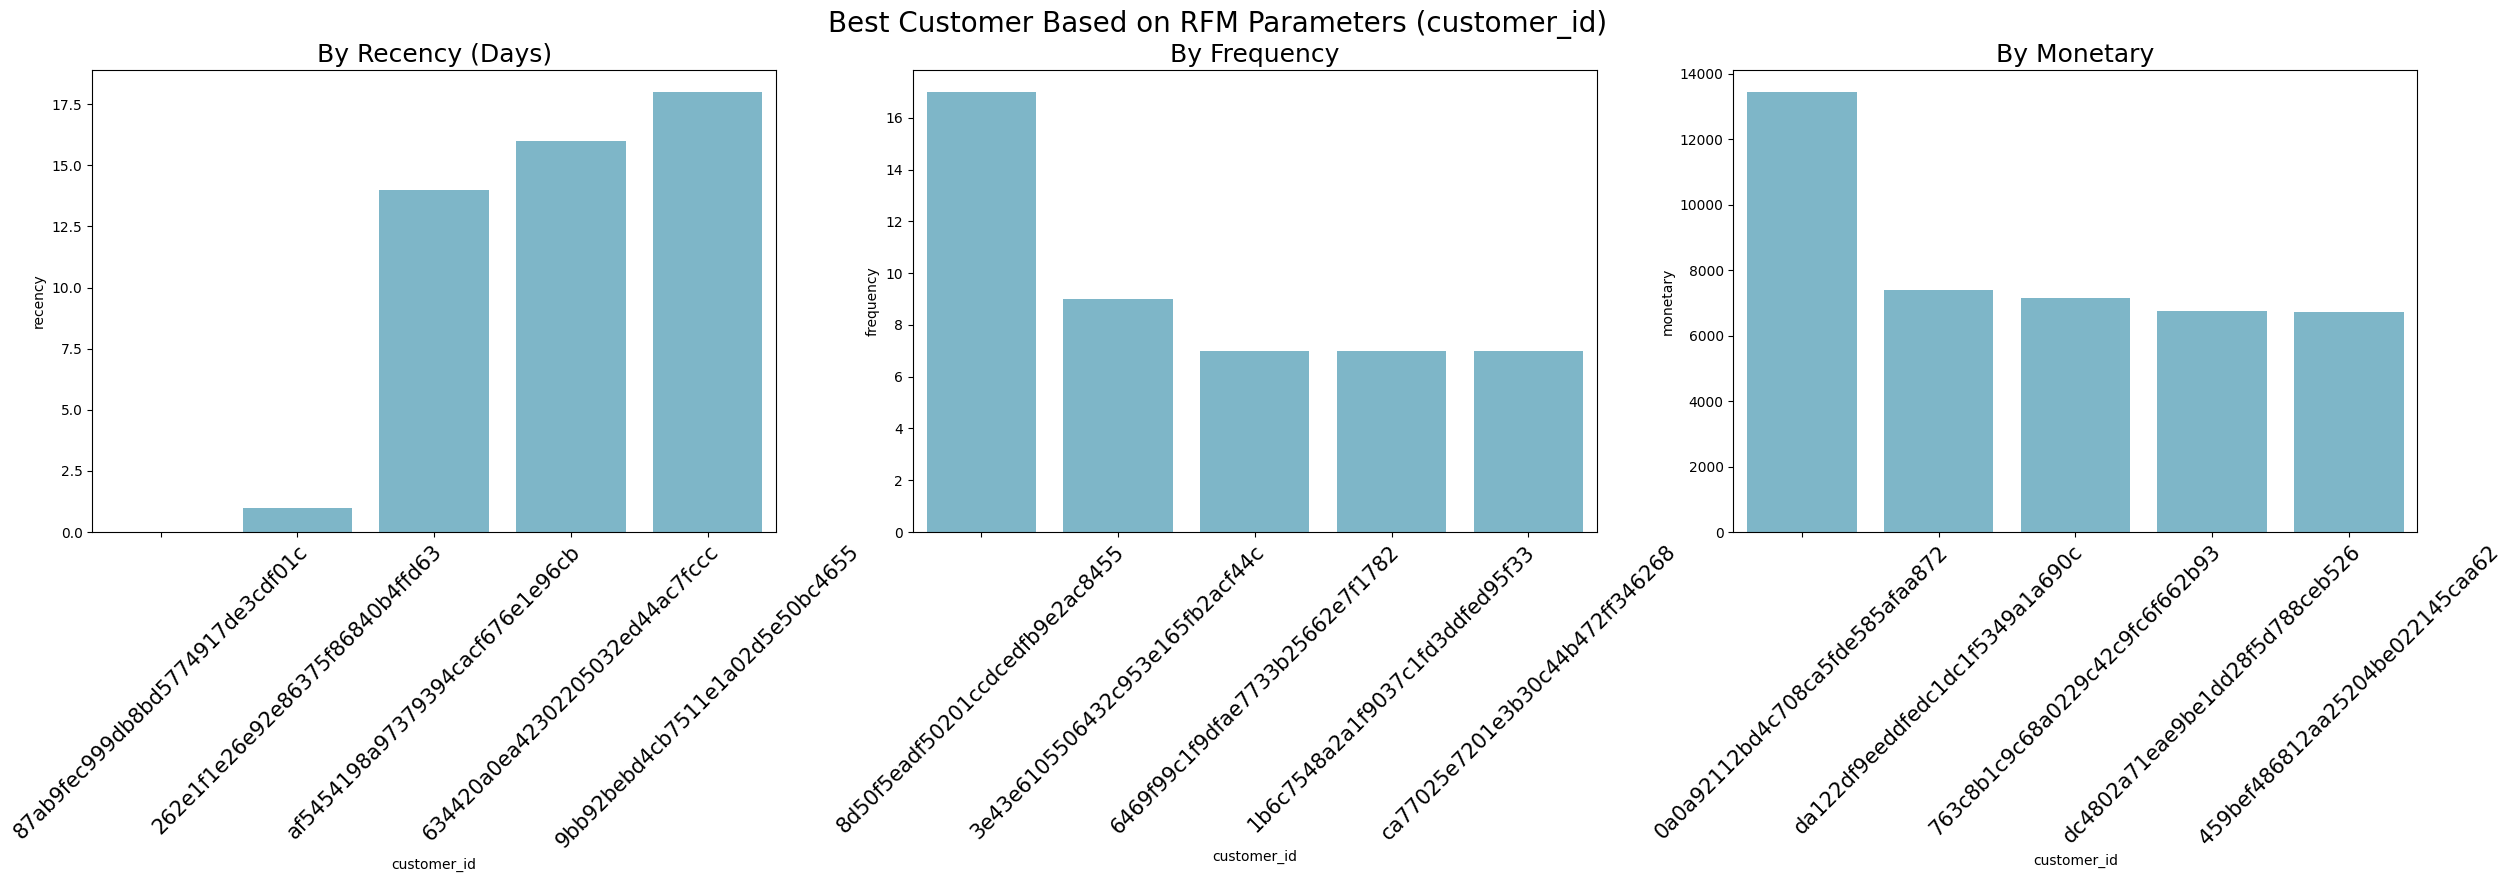

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

# Recency
sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_title("By Recency (Days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=15, labelrotation=45)

# Frequency
sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15, labelrotation=45)

# Monetary
sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2])
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=15, labelrotation=45)

plt.suptitle("Best Customer Based on RFM Parameters (customer_id)", fontsize=20)
plt.show()

## Conclusion

- **Conclussion pertanyaan 1:** Produk yang memberikan pendapatan tertinggi adalah 'beleza_saude' (Kesehatan & Kecantikan), sedangkan yang terendah adalah 'seguros_e_servicos' (Asuransi & Servis). Strategi promosi bisa difokuskan pada kategori terlaris, sementara kategori terendah perlu dievaluasi.

- **Conclussion pertanyaan 2:** Mayoritas pelanggan berasal dari Negara Bagian SP (São Paulo). Hal ini menunjukkan dominasi pasar di wilayah tersebut, sehingga logistik dan pemasaran dapat dipusatkan di sana untuk efisiensi.

- **Conclussion pertanyaan 3:** Melalui analisis RFM, kita berhasil mengidentifikasi pelanggan setia (Frequency tinggi) dan pelanggan yang baru saja bertransaksi (Recency rendah). Pelanggan-pelanggan ini dapat dijadikan target program loyalitas atau promosi khusus.